In [6]:
# Initialization
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.utils import to_categorical # one-hot-encoding

# Required for loss function
import math
from tensorflow.python.keras import losses

import tensorflow as tf

In [8]:
# Set someparameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
# Original size = 572*572
LABEL_CLASS = 3

MODEL_NAME = 'model-lab-unet-iou.h5'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [9]:
# Define pre-process function

from skimage.transform import resize

def pre_process(img, img_height, img_width, norm = False, rescale = False, mask = False):
    img = np.array(img)                 #list to array
    proc_img = []
    
    #proc_img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
        
    if mask:
        proc_img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    else:
        proc_img = img[:,:,np.newaxis]
        proc_img = resize(img, (img_height, img_width, 1), mode='constant', preserve_range=True)
        
    if rescale:
        proc_img /= 255
        
    #image normalization
    if norm:
        #adjusted_std = max(np.std(proc_img), 1.0/np.sqrt(proc_img.size))
        ipsilon = 0.0001
        proc_img = (proc_img-np.mean(proc_img))/np.std(proc_img)+ipsilon
        
    return proc_img

In [10]:
# Importing data...

# Path for Linux
#TRAIN_PATH = '/home/ziheng/UNet/dataset_lab/train/'
#TEST_PATH = '/home/ziheng/UNet/dataset_lab/test/'

# Path for Windows
TRAIN_PATH = 'F:\\MA\\data\\dataset_lab\\train\\'
TEST_PATH = 'F:\MA\\data\\dataset_lab\\test\\'

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH + 'in/'))[2]
test_ids = next(os.walk(TEST_PATH + 'in/'))[2]

# X_test: original images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype='float')
# Y_test: masks
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    
    
# Get and resize test images
print('Getting and resizing test images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    
    img = imread(TEST_PATH + 'in/' + id_)
    X_test[n] = pre_process(img, IMG_HEIGHT, IMG_WIDTH, norm = False, rescale = True)
    
    mask = imread(TEST_PATH + 'out-cell/' + id_.replace('.jpg', '.png'))
    mask = to_categorical(mask, LABEL_CLASS) # Generate binary masks (one hot encoding)
    # Resizing need to be done AFTER one-hot encoding!!!!!!!
    mask = pre_process(mask, IMG_HEIGHT, IMG_WIDTH, mask = True)
    Y_test[n] = mask
    
    
print('Done!')

Getting and resizing test images ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 16.03it/s]


Done!


In [11]:
def IoU(y_true,y_pred):
    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = intersection / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f))
    return score

def IoU_loss(y_true , y_pred):
    loss = 1 - IoU(y_true, y_pred)
    return loss

In [12]:
# Define custom metrics and loss functions
def dice_coeff(y_true,y_pred):
    smooth = 1.
    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true , y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss (y_true, y_pred):
    loss = losses.categorical_crossentropy(y_true,y_pred)+dice_loss(y_true,y_pred)
    return loss

# The same as log_loss
def mlogloss(target, pred):
    score = 0.0
    for i in range(len(pred)):
        pp = pred[i]
        for j in range(len(pp)):
            prob = pp[j]
            if prob < 1e-15:
                prob = 1e-15
            score += target[i][j] * math.log(prob)
    return -score/len(pred)

In [14]:
# Predict on train, val and test
model = load_model('.\\model\\' + MODEL_NAME, custom_objects={'bce_dice_loss': IoU_loss, 'IoU': IoU, 'dice_loss': dice_loss})
#preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
#preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
#preds_train_t = (preds_train > 0.5).astype(np.uint8)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
#for i in range(len(preds_test)):
#    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
#                                       (sizes_test[i][0], sizes_test[i][1]), 
#                                       mode='constant', preserve_range=True))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
34/34 [==============================] - ETA:  - 2s 62ms/step


In [15]:
print(preds_test_t.shape)

(34, 128, 128, 3)


24


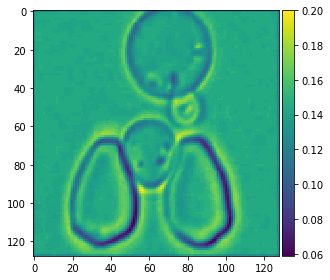

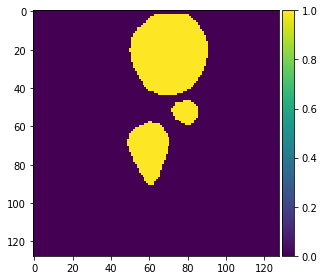

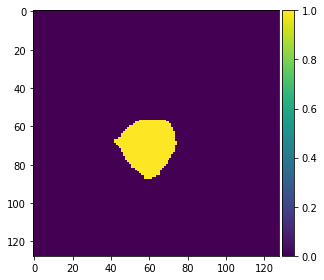

In [23]:
# Perform a test on prediction result
ix = random.randint(0, len(test_ids)-1)
#ix = 25
print(ix)
mask_category = 2 # Choose the mask nummer 0,1,2
imshow(np.reshape(X_test[ix], (IMG_WIDTH, IMG_HEIGHT)))
plt.show()
imshow(np.squeeze(Y_test[ix,:,:,mask_category])) 
plt.show()
imshow(np.squeeze(preds_test_t[ix,:,:,mask_category]))
plt.show()

In [24]:
# Generate the mask wihtout one-hot-encoding 
preds_test_mask = np.zeros(shape=(preds_test_t.shape[0], preds_test_t.shape[1], preds_test_t.shape[2]))

for i in range(preds_test_t.shape[0]):
    for y in range(preds_test_t.shape[1]):
        for x in range(preds_test_t.shape[2]):
            if preds_test_t[i, y, x, 1] == 1:
                preds_test_mask[i, y, x] = 1
            elif preds_test_t[i, y, x, 2] == 1:
                preds_test_mask[i, y, x] = 2
            else:
                preds_test_mask[i, y, x] = 0

27


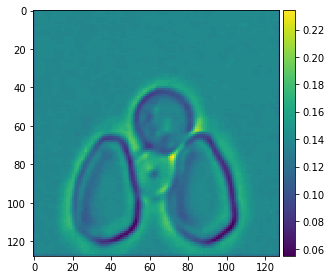

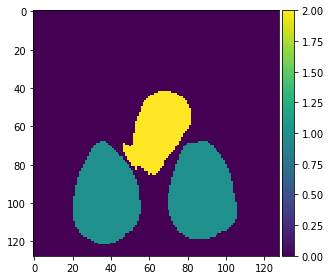

In [29]:
# Generate and show the test image + the prediction masks
ix = random.randint(0, len(test_ids)-1)
#ix = 25
print(ix)

imshow(np.reshape(X_test[ix], (IMG_WIDTH, IMG_HEIGHT)))
plt.show()

imshow(np.squeeze(preds_test_mask[ix]))
plt.show()

11


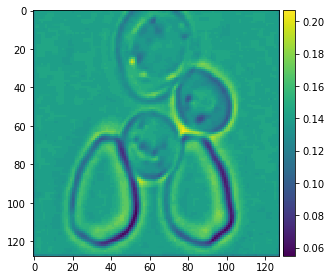

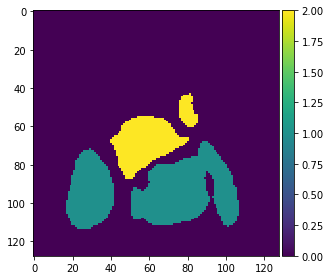

In [30]:
################### Don't run unless you want to generate images!!!!!!! ######################
##############################################################################################
# Generate and save the test image + the prediction masks
#ix = random.randint(0, len(test_ids))
ix = 11
print(ix)
plt.figure()
imshow(np.reshape(X_test[ix], (IMG_WIDTH, IMG_HEIGHT)))
#plt.show()
plt.savefig('test_img_' + str(ix) + '.png')
#imshow(np.squeeze(Y_test[ix,:,:,mask_category])) 
#plt.show()
plt.figure()
imshow(np.squeeze(preds_test_mask[ix]))
#plt.show()
plt.savefig('preds_mask_' + str(ix) + '.png')

In [31]:
# Define evaluation metrics
def metric_IoU(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    return np.sum(intersection) / np.sum(union)

def metric_precision(target, prediction):
    target_bool = np.array(target, dtype = 'bool')
    prediction_bool = np.array(prediction, dtype = 'bool')
    TP = np.logical_and(target_bool, prediction_bool)
    FP = np.logical_and(~target_bool, prediction_bool)
    return np.sum(TP) / (np.sum(TP)+np.sum(FP))    
    
def metric_recall(target, prediction):
    target_bool = np.array(target, dtype = 'bool')
    prediction_bool = np.array(prediction, dtype = 'bool')
    TP = np.logical_and(target_bool, prediction_bool)
    FN = np.logical_and(target_bool, ~prediction_bool)
    return np.sum(TP) / (np.sum(TP)+np.sum(FN))
    
def metric_f1(target, prediction):
    precision = metric_precision(target, prediction)
    recall = metric_recall(target, prediction)
    return 2*precision*recall/(precision+recall)

In [32]:
IoU_score = []
class_IoU_score = []
class_f1_score = []
class_precision_score = []
class_recall_score =  []

for d in range(Y_test.shape[3]):
    class_IoU_score.append([])
    class_f1_score.append([])
    class_precision_score.append([])
    class_recall_score.append([])

for i in range(len(X_test)):
    IoU_score.append(metric_IoU(Y_test[i], preds_test_t[i]))
    for d in range(Y_test.shape[3]):
        class_IoU_score[d].append(metric_IoU(Y_test[i,:,:,d], preds_test_t[i,:,:,d]))
        class_f1_score[d].append(metric_f1(Y_test[i,:,:,d], preds_test_t[i,:,:,d]))
        class_precision_score[d].append(metric_precision(Y_test[i,:,:,d], preds_test_t[i,:,:,d]))
        class_recall_score[d].append(metric_recall(Y_test[i,:,:,d], preds_test_t[i,:,:,d]))
        
IoU_score = np.array(IoU_score)
class_IoU_score = np.array(class_IoU_score)
class_f1_score = np.array(class_f1_score)
class_precision_score = np.array(class_precision_score)
class_recall_score = np.array(class_recall_score)

IoU_result = pd.DataFrame(data = class_IoU_score.transpose(), columns = ['Background', 'Trap', 'Cell'])
f1_result = pd.DataFrame(data = class_f1_score.transpose(), columns = ['Background', 'Trap', 'Cell'])
precision_result = pd.DataFrame(data = class_precision_score.transpose(), columns = ['Background', 'Trap', 'Cell'])
recall_result = pd.DataFrame(data = class_recall_score.transpose(), columns = ['Background', 'Trap', 'Cell'])

C:\Anaconda\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


In [33]:
IoU_result.head()

,Background,Trap,Cell
0,0.764648,0.456102,0.000000
1,0.779947,0.737513,0.459815
2,0.762876,0.516561,0.000000
3,0.807670,0.710181,0.000000
4,0.544887,0.616896,0.166891


In [34]:
IoU_result.describe()

,Background,Trap,Cell
count,34.000000,34.000000,34.000000
mean,0.716128,0.672885,0.338905
std,0.100962,0.119318,0.247315
min,0.510660,0.456102,0.000000
25%,0.633777,0.571174,0.167488
50%,0.763762,0.713651,0.289670
75%,0.794921,0.758910,0.563183
max,0.851531,0.863589,0.769923


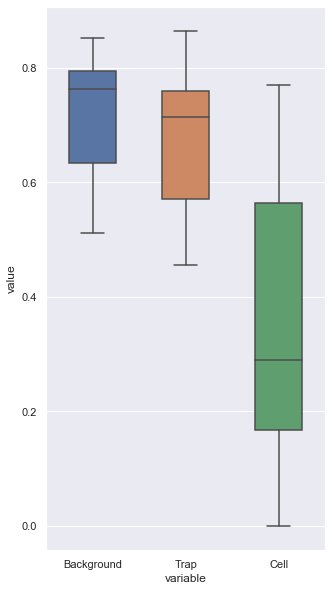

In [35]:
sns.set(rc={'figure.figsize':(5, 10)})
sns.boxplot(x="variable", y="value", data=pd.melt(IoU_result), width = 0.5)
#sns.boxplot(IoU_result)

plt.show()

In [36]:
f1_result.head()

,Background,Trap,Cell
0,0.866630,0.626470,NaN
1,0.876371,0.848929,0.629963
2,0.865490,0.681226,NaN
3,0.893603,0.830533,NaN
4,0.705407,0.763062,0.286044


In [37]:
f1_result.describe()

,Background,Trap,Cell
count,34.000000,34.000000,29.000000
mean,0.830500,0.798321,0.533323
std,0.071625,0.088866,0.235966
min,0.676075,0.626470,0.045848
25%,0.775822,0.727033,0.361119
50%,0.866060,0.832896,0.593870
75%,0.885745,0.862926,0.775281
max,0.919813,0.926802,0.870007


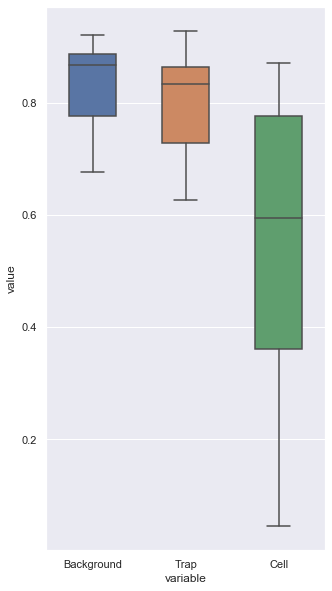

In [38]:
sns.set(rc={'figure.figsize':(5, 10)})
sns.boxplot(x="variable", y="value", data=pd.melt(f1_result), width = 0.5)
#sns.boxplot(IoU_result)

plt.show()